**A 1D convolutional net with one GRU Layer in Keras.**

The data is directly fed into the net where it passes Conv + MaxPool to detect features, then it goes into a GRU + Dropout then activation.

It trains fast (less than 5 minutes on my GTX 970) and usually gets an F1 Score > 0.8 and can go up to 1.00 but i'd like to test it on more test data to check if it overfits.

Any comments appreciated.

In [1]:
import numpy as np
import pandas as pd
from numpy.random import seed
from tensorflow import set_random_seed

from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score

from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Input, Conv1D, GRU, Flatten, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline  

Using TensorFlow backend.


This function is used to visualize if the model make good predictions on the skewed class.

In [2]:
# Display test set precision recall curve
def display_precision_recall_curve(reference, score):
    """
    Function to display the precision recall for a reference set.
    
    Arguments:
    reference -- the reference labels given for the set
    score -- the score computed 

    Returns:
    null
    """
    average_precision = average_precision_score(reference, score)
    precision, recall, _ = precision_recall_curve(reference, score)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [3]:
from keras import backend as K
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

The simple model we will be using.

In [4]:
def model(input_shape):
    """
    Function creating the Exo_detector model.
    
    Arguments:
    input_shape -- shape of the input

    Returns:
    model -- a model instance in Keras
    """
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV + MaxPool layer to detect patterns
    X = Conv1D(32, kernel_size=10, strides=4)(X_input)
    X = MaxPooling1D(pool_size=4, strides=2)(X)
    X = Activation('relu')(X)
    
    # Step 2: GRU Layer
    X = GRU(192,return_sequences=True)(X)
    X = Flatten()(X)
    
    # Final sigmoid activation layer
    X = Dropout(0.5)(X)                                 
    X = BatchNormalization()(X)    
    X = Dense(1, activation="sigmoid")(X)

    model = Model(inputs= X_input, outputs = X)
    
    return model  

Importing the train then the test set.

Note that we have to reshape X to 3D (n, m , 1) because it is required by the first Conv1D Layer.

In [5]:
# get traincsv files
train = pd.read_csv("./exoTrain.csv")
nx, m = train.shape
m -= 1

y_train = train['LABEL'].values
y_train -=1

X_train = train.drop('LABEL', axis=1).values.reshape(nx, m, 1)

print("Train set: \nNumber of examples={0}\nNumber of readings={1}".format(nx, m))

Train set: 
Number of examples=5087
Number of readings=3197


In [6]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([5050,   37]))

In [7]:
# get testcsv files
test = pd.read_csv("./exoTest.csv")
ny, my = test.shape
my -= 1

y_test = test['LABEL'].values
y_test -= 1

X_test = test.drop('LABEL',axis=1).values.reshape(ny, m, 1)

assert m == my, "Error: train and test set have not the same number of timesteps"

print("Train set: \nNumber of examples={0}\nNumber of readings={1}".format(ny, my))

Train set: 
Number of examples=570
Number of readings=3197


Preparing the model and displaying a summary to check the output layers and trainable parameters.

In [8]:
# Set a seed for reproducibility
seed(42)
set_random_seed(42)

# prepare model
gru_model = model(input_shape = (m, 1))
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
gru_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[recall_m,f1_m,precision_m, 'accuracy'])

# check model shapes
gru_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3197, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 797, 32)           352       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 397, 32)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 397, 32)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 397, 192)          129600    
_________________________________________________________________
flatten_1 (Flatten)  

I'm increasing the positive example weight because of the unbalanced set.

I also take a batch size of 128 so as to minimize the chance the minibatch has no positive example. Not sure if this is a good approach.

4 epochs are enough for the model to give good results sometimes, one more epoch may be necessary.

I'd like to have better metrics for this part.

In [9]:
# raise positive examples weight because of skewed classes and fit the model
class_weight = {0: 1., 1: 140}
gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=2, shuffle=True, class_weight=class_weight)

Instructions for updating:
Use tf.cast instead.
Train on 5087 samples, validate on 570 samples
Epoch 1/2
5087/5087 [==============================] - 18s 4ms/step - loss: 1.3346 - recall_m: 0.4697 - f1_m: 0.0261 - precision_m: 0.0135 - acc: 0.5677 - val_loss: 0.5929 - val_recall_m: 0.2246 - val_f1_m: 0.0522 - val_precision_m: 0.0295 - val_acc: 0.7439
Epoch 2/2
5087/5087 [==============================] - 15s 3ms/step - loss: 0.7954 - recall_m: 0.5787 - f1_m: 0.0439 - precision_m: 0.0229 - acc: 0.7012 - val_loss: 0.3574 - val_recall_m: 0.1796 - val_f1_m: 0.0749 - val_precision_m: 0.0473 - val_acc: 0.8789


In [10]:
gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=4, shuffle=True, class_weight=class_weight)

Train on 5087 samples, validate on 570 samples
Epoch 1/4
5087/5087 [==============================] - 15s 3ms/step - loss: 0.5573 - recall_m: 0.5787 - f1_m: 0.0627 - precision_m: 0.0336 - acc: 0.8032 - val_loss: 0.2438 - val_recall_m: 0.2246 - val_f1_m: 0.1404 - val_precision_m: 0.1021 - val_acc: 0.9561
Epoch 2/4
5087/5087 [==============================] - 15s 3ms/step - loss: 0.4971 - recall_m: 0.5536 - f1_m: 0.0847 - precision_m: 0.0467 - acc: 0.8575 - val_loss: 0.1967 - val_recall_m: 0.2246 - val_f1_m: 0.1604 - val_precision_m: 0.1248 - val_acc: 0.9596
Epoch 3/4
5087/5087 [==============================] - 15s 3ms/step - loss: 0.4010 - recall_m: 0.6794 - f1_m: 0.0971 - precision_m: 0.0530 - acc: 0.8701 - val_loss: 0.1572 - val_recall_m: 0.2246 - val_f1_m: 0.1871 - val_precision_m: 0.1604 - val_acc: 0.9719
Epoch 4/4
5087/5087 [==============================] - 15s 3ms/step - loss: 0.3567 - recall_m: 0.5284 - f1_m: 0.1159 - precision_m: 0.0678 - acc: 0.8986 - val_loss: 0.1336 - val_r

Time to evaluate on the trainning set.

Usually the AP=1.00, and the model makes no mistake which would indicate that the model overfits but we have the same kind of results with the test set.

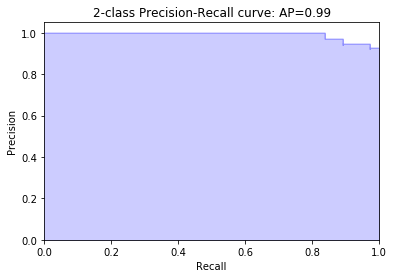

In [11]:
# Predict scores with trained model
y_train_score = gru_model.predict(X_train).flatten()
# Display precision_recall_curve for train set
display_precision_recall_curve(y_train, y_train_score)

The test set is usually nearly as good as the train with AP>0.8 and can go up to 1.0

I'd like to try it on some more data to see what I can do to improve it because we only have 5 positive examples in this set.

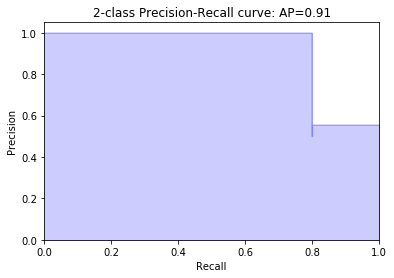

In [12]:
# Predict scores for test set
y_test_score = gru_model.predict(X_test).flatten()
# Display test set precision recall curve
display_precision_recall_curve(y_test, y_test_score)

I look for a threshold that gives me the best score I can get for this model.

Best Threshold 0.797, fscore 0.81319 , precision 0.68519 , recall 1.00000


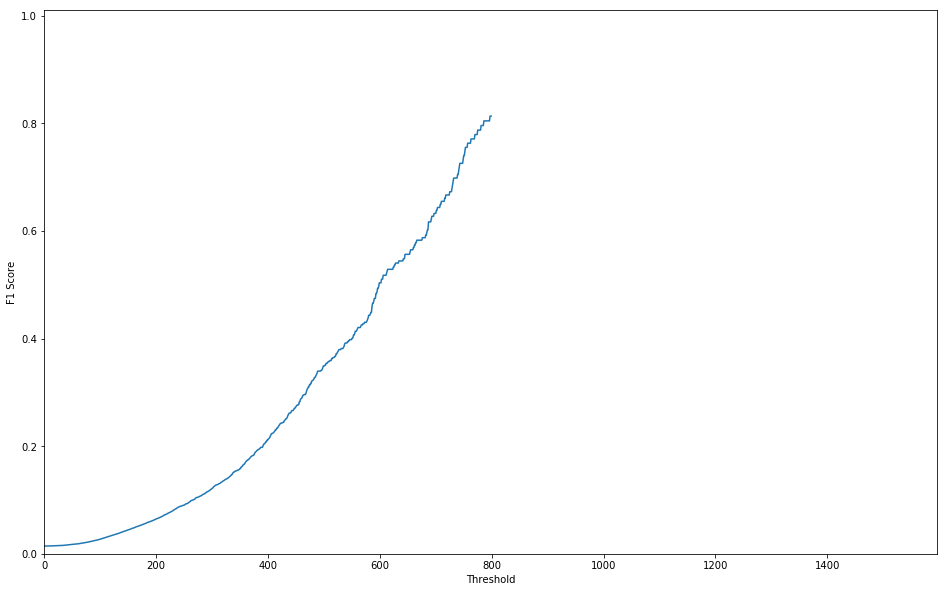

In [13]:
# Compute f_scores and choose best threshold value
f_scores_train = []
for i in range(800):
    f_scores_train.append(f1_score(y_train,np.where(y_train_score > i/1000,1,0)))
imax_train = np.argmax(f_scores_train)
y_max_train = np.where(y_train_score > imax_train/1000,1,0)

threshold_train = np.median((np.where(f_scores_train == f_scores_train[imax_train])[0]))/1000
print('Best Threshold {0:0.3f}, fscore {1:0.5f} , precision {2:0.5f} , recall {3:0.5f}'.format(imax_train/1000, f_scores_train[imax_train], precision_score(y_train, y_max_train), recall_score(y_train, y_max_train)))

plt.figure(figsize=(16,10))
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.xlim([0.0, threshold_train*2000])
plt.ylim([0.0, 1.01])
plt.plot(f_scores_train)

Best Threshold 0.636, fscore 0.88889 , precision 1.00000 , recall 0.80000


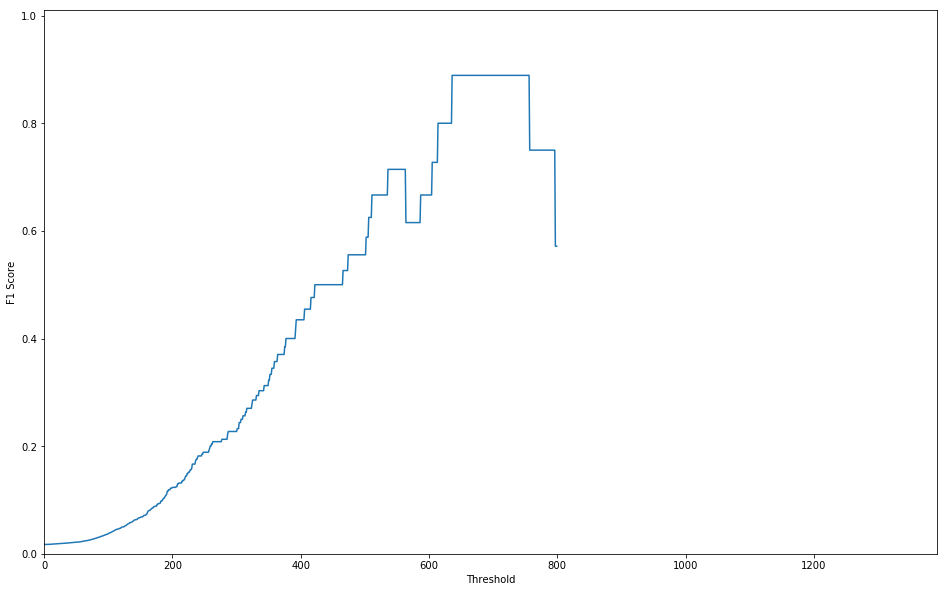

In [14]:
# Compute f_scores and choose best threshold value
f_scores = []
for i in range(800):
    f_scores.append(f1_score(y_test,np.where(y_test_score > i/1000,1,0)))
imax = np.argmax(f_scores)
y_max = np.where(y_test_score > imax/1000,1,0)

threshold = np.median((np.where(f_scores == f_scores[imax])[0]))/1000
print('Best Threshold {0:0.3f}, fscore {1:0.5f} , precision {2:0.5f} , recall {3:0.5f}'.format(imax/1000, f_scores[imax], precision_score(y_test, y_max), recall_score(y_test, y_max)))

plt.figure(figsize=(16,10))
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.xlim([0.0, threshold*2000])
plt.ylim([0.0, 1.01])
plt.plot(f_scores)

This will show which of the positives examples where correctly identified and which were not.
Most of the times, one sample is missing or they are all present but there is an extra false positive.

In [15]:
# Look at predicted positive labels:
threshold_train=imax_train/1000
y_hat = np.where(y_test_score>=threshold_train,1,0)
print("F1_Score {0:4f} at threshold {1:4f}\n".format(f1_score(y_test, y_hat), threshold_train))

print("Predicted ExoPlanet samples", np.where(y_test_score>=threshold_train)[0])
print("Actual ExoPlanet Samples", np.where(y_test==1)[0])
print(y_test_score[0])


F1_Score 0.571429 at threshold 0.797000

Predicted ExoPlanet samples [1 4]
Actual ExoPlanet Samples [0 1 2 3 4]
0.56385255


In [16]:
#Using threshold as 0.9
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve
y_hat = gru_model.predict(X_test)[:,0]
y_pred = np.where(y_hat > threshold_train,1.,0.)

#y_pred = gru_model.predict_classes(X_test)


# accuracy: (tp + tn) / (p + n)
print('Accuracy:', accuracy_score(y_test, y_pred))
# f1: 2 tp / (2 tp + fp + fn)
print('F1 score:', f1_score(y_test, y_pred))
# recall: tp / (tp + fn)
print('Recall:', recall_score(y_test, y_pred))
# precision tp / (tp + fp)
print('Precision:', precision_score(y_test, y_pred))
#cohen's kappa
print('Cohens Kappa :', cohen_kappa_score(y_test, y_pred))
#AUC score
print('ROC AUC Score:', roc_auc_score(y_test, y_pred))
#Classification report
print('\n clasification report:\n', classification_report(y_test,y_pred))
#Confusion matrix
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy: 0.9947368421052631
F1 score: 0.5714285714285715
Recall: 0.4
Precision: 1.0
Cohens Kappa : 0.5692695214105794
ROC AUC Score: 0.7

 clasification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       1.00      0.40      0.57         5

    accuracy                           0.99       570
   macro avg       1.00      0.70      0.78       570
weighted avg       0.99      0.99      0.99       570


 confussion matrix:
 [[565   0]
 [  3   2]]


In [17]:
#y_train_pred = model_two.predict_classes(x_train)[:,0]
y_train_hat = gru_model.predict(X_train)[:,0]
y_train_pred = np.where(y_train_hat > threshold_train,1.,0.)
print('Accuracy:', accuracy_score(y_train, y_train_pred))
print('F1 score:', f1_score(y_train, y_train_pred))
print('Recall:', recall_score(y_train, y_train_pred))
print('Precision:', precision_score(y_train, y_train_pred))
print('Cohens Kappa :', cohen_kappa_score(y_train, y_train_pred))
print('ROC AUC Score:', roc_auc_score(y_train, y_train_pred))
print('\n clasification report:\n', classification_report(y_train, y_train_pred))
print('\n confussion matrix:\n',confusion_matrix(y_train, y_train_pred))

Accuracy: 0.9966581482209553
F1 score: 0.8131868131868133
Recall: 1.0
Precision: 0.6851851851851852
Cohens Kappa : 0.811560159591738
ROC AUC Score: 0.9983168316831683

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       0.69      1.00      0.81        37

    accuracy                           1.00      5087
   macro avg       0.84      1.00      0.91      5087
weighted avg       1.00      1.00      1.00      5087


 confussion matrix:
 [[5033   17]
 [   0   37]]
